# 🤖 03 - Baseline Model: Predicting Energy Prices
This notebook trains a baseline XGBoost model to predict hourly energy prices.

In [2]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 3.4 MB/s eta 0:00:45
   ---------------------------------------- 1.3/150.0 MB 4.2 MB/s eta 0:00:36
    --------------------------------------- 2.1/150.0 MB 3.7 MB/s eta 0:00:41
    --------------------------------------- 2.9/150.0 MB 3.8 MB/s eta 0:00:39
   - -------------------------------------- 4.2/150.0 MB 4.3 MB/s eta 0:00:34
   - -------------------------------------- 5.2/150.0 MB 4.4 MB/s eta 0:00:34
   - -------------------------------------- 6.3/150.0 MB 4.4 MB/s eta 0:00:33
   - -------------------------------------- 6.8/150.0 MB 4.2 MB/s eta 0:00:35
   -- ------------------------------------- 7.6/150.0 MB 4.1 MB/s eta 0:00:35
   -- ------------------------------------- 7.9/150.0 MB 4.0 MB/s eta 0:00:36
   -- ------------------------------------- 8.7/150.0 MB 3.8 MB/s eta 0:00:38
   -- ------------------------------------- 9.2/150.0 MB 3.9 MB/s eta 0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv('../data/processed/merged_energy_data_final_step_1.csv', parse_dates=['utc_timestamp'])
df.set_index('utc_timestamp', inplace=True)
df = df.sort_index()
df.head()

,cet_cest_timestamp,DE_load_actual_entsoe_transparency,DE_solar_capacity,DE_solar_generation_actual,DE_wind_capacity,DE_wind_generation_actual,Price (EUR/MWhe),DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,Gas_Price,Oil_Price
utc_timestamp,,,,,,,,,,,,
2014-12-31 23:00:00,2015-01-01T00:00:00+0100,NaN,37248.0,0.0,27913.0,NaN,NaN,NaN,NaN,NaN,3.14,55.38
2015-01-01 00:00:00,2015-01-01T01:00:00+0100,41151.0,37248.0,0.0,27913.0,8852.0,22.34,-0.981,0.0,0.0,3.14,55.38
2015-01-01 01:00:00,2015-01-01T02:00:00+0100,40135.0,37248.0,0.0,27913.0,9054.0,22.34,-1.035,0.0,0.0,3.14,55.38
2015-01-01 02:00:00,2015-01-01T03:00:00+0100,39106.0,37248.0,0.0,27913.0,9070.0,22.34,-1.109,0.0,0.0,3.14,55.38
2015-01-01 03:00:00,2015-01-01T04:00:00+0100,38765.0,37248.0,0.0,27913.0,9163.0,22.34,-1.166,0.0,0.0,3.14,55.38


## 📌 Feature Engineering

In [3]:
# Define features and target
target = 'Price (EUR/MWhe)'
features = [
    'DE_solar_generation_actual',
    'DE_wind_generation_actual',
    'DE_load_actual_entsoe_transparency',
    'Gas_Price',
    'Oil_Price',
    'DE_radiation_direct_horizontal',
    'DE_radiation_diffuse_horizontal',
    'DE_temperature'
]

# Lag features
df['price_lag_1h'] = df['Price (EUR/MWhe)'].shift(1)
df['price_lag_24h'] = df['Price (EUR/MWhe)'].shift(48)
df['price_lag_168h'] = df['Price (EUR/MWhe)'].shift(192)

# Rolling averages
df['price_roll_24h'] = df['Price (EUR/MWhe)'].rolling(24).mean()
df['price_roll_168h'] = df['Price (EUR/MWhe)'].rolling(168).mean()
df['price_roll_t48_t24'] = df['Price (EUR/MWhe)'].shift(48).rolling(window=24).mean()
df['price_roll_t192_t24'] = df['Price (EUR/MWhe)'].shift(48).rolling(window=168).mean()

# Calendar features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

# Ratio features
df['solar_load_ratio'] = df['DE_solar_generation_actual'] / df['DE_load_actual_entsoe_transparency']
df['wind_load_ratio'] = df['DE_wind_generation_actual'] / df['DE_load_actual_entsoe_transparency']

# Final feature list
features += [
    'price_lag_24h', 
    'price_lag_168h',
    'price_roll_t48_t24',
    'price_roll_t192_t24',
    #'price_roll_24h', 
    #'price_roll_168h',
    'hour', 'dayofweek', 'month',
    'solar_load_ratio', 'wind_load_ratio'
]

# Drop rows with missing values (due to shifting/rolling)
df_model = df[features + ['Price (EUR/MWhe)']].dropna()

## 📆 Train-Test Split (Time-Based)

In [4]:
# Use 2015-2018 for training, 2019 for testing
train = df_model[df_model.index < '2019-01-01']
test = df_model[df_model.index >= '2019-01-01']

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

print(f'Train size: {X_train.shape}, Test size: {X_test.shape}')

Train size: (34849, 17), Test size: (8713, 17)


## 🚀 Train XGBoost Regressor

In [5]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

## 📊 Evaluate the Model

In [6]:
# Compute error metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE: 6.47
RMSE: 9.45


## 📉 Plot Actual vs Predicted

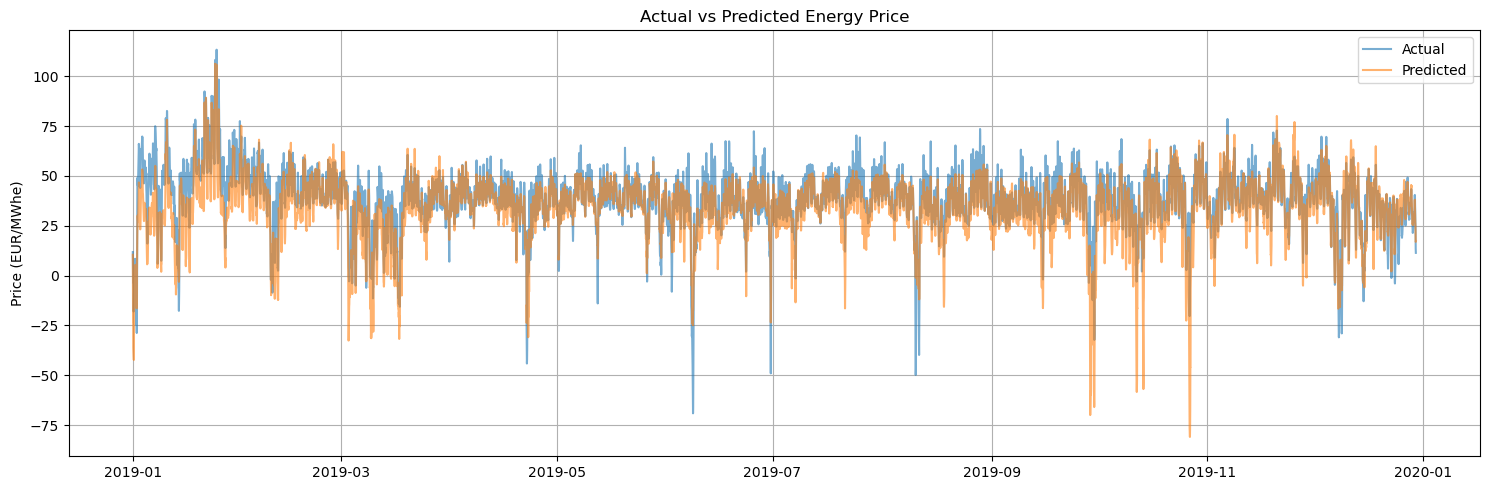

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test.values, label='Actual', alpha=0.6)
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.6)
plt.title('Actual vs Predicted Energy Price')
plt.ylabel('Price (EUR/MWhe)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
final_df=df_model
# Align predictions and actuals to matching index
aligned_index = y_test.index[:len(y_pred)]
y_pred_series = pd.Series(y_pred, index=aligned_index, name="y_pred")
y_test_aligned = y_test.loc[aligned_index]

# Load values aligned to the same index
load_test = final_df.loc[aligned_index, 'DE_load_actual_entsoe_transparency']

# Calculate costs
predicted_total_cost = (y_pred_series * load_test).sum()
actual_total_cost = (y_test_aligned * load_test).sum()

# Print comparison
print(f"💸 Total Predicted Cost: €{predicted_total_cost:,.2f}")
print(f"✅ Total Actual Cost:    €{actual_total_cost:,.2f}")
print(f"📉 Absolute Difference:  €{abs(predicted_total_cost - actual_total_cost):,.2f}")
print(f"📊 Percentage Error:     {100 * abs(predicted_total_cost - actual_total_cost) / actual_total_cost:.2f}%")


💸 Total Predicted Cost: €16,882,472,846.07
✅ Total Actual Cost:    €19,167,122,677.41
📉 Absolute Difference:  €2,284,649,831.34
📊 Percentage Error:     11.92%


pkl file

In [9]:
import joblib

# Assuming your model variable is named `model`
joblib.dump(model, "../saved_models/U48h.pkl")
print("✅ Model saved as U48h.pkl")


✅ Model saved as U48h.pkl


This following code is to find the most prominent features

📊 Top Features by Importance:


,Feature,Importance
8,price_lag_24h,0.403896
16,wind_load_ratio,0.168850
9,price_lag_168h,0.104818
15,solar_load_ratio,0.060166
2,DE_load_actual_entsoe_transparency,0.052422
13,dayofweek,0.045268
5,DE_radiation_direct_horizontal,0.023511
11,price_roll_t192_t24,0.020589
14,month,0.020497
3,Gas_Price,0.020274


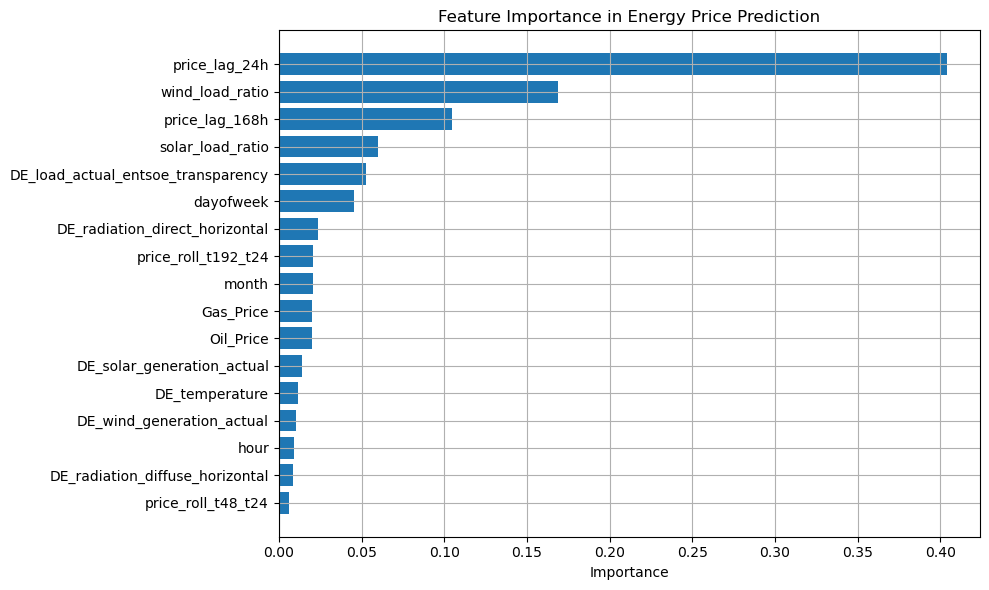

In [8]:
# Extract feature importance after training the model
importances = model.feature_importances_

# If you trained on df_model[features]
feature_names = features  # this is your list of selected input features

# Wrap into DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display
print("📊 Top Features by Importance:")
display(importance_df)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance in Energy Price Prediction")
plt.xlabel("Importance")
plt.grid(True)
plt.tight_layout()
plt.show()


📉 Smoothed Derivative Model → MAE: 1.278, RMSE: 1.935


C:\Users\iTECH\AppData\Local\Temp\ipykernel_13628\107167341.py:47: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\iTECH\.julia\conda\3\x86_64\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


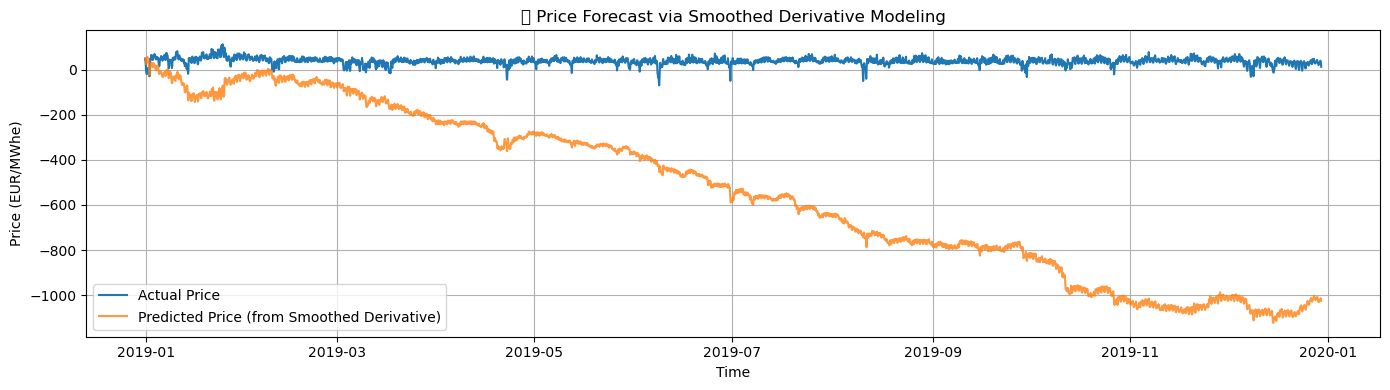

In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

final_df=df_model
# 1. Compute the smoothed price derivative
final_df['price_derivative'] = final_df['Price (EUR/MWhe)'].diff()
final_df['price_derivative_smooth'] = final_df['price_derivative'].rolling(window=3, center=True).mean()
final_df = final_df.dropna()

# 2. Split features and target
X = final_df[features]
y = final_df['price_derivative_smooth']

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 4. Train model
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Predict smoothed derivative
y_pred_diff = model.predict(X_test)

# 6. Reconstruct the price from derivative
start_price = final_df['Price (EUR/MWhe)'].iloc[X_train.shape[0]]
reconstructed_price = np.cumsum(np.insert(y_pred_diff, 0, start_price))[:-1]

# 7. Evaluate
mae = mean_absolute_error(y_test, y_pred_diff)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_diff))
print(f"📉 Smoothed Derivative Model → MAE: {mae:.3f}, RMSE: {rmse:.3f}")

# 8. Plot reconstructed price
actual_price_test = final_df['Price (EUR/MWhe)'].iloc[X_train.shape[0]:]

plt.figure(figsize=(14, 4))
plt.plot(actual_price_test.index, actual_price_test.values, label='Actual Price')
plt.plot(actual_price_test.index, reconstructed_price, label='Predicted Price (from Smoothed Derivative)', alpha=0.8)
plt.title("📈 Price Forecast via Smoothed Derivative Modeling")
plt.xlabel("Time")
plt.ylabel("Price (EUR/MWhe)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
